In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import zscore, probplot
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
data = pd.read_csv("train.csv")
evaluation = pd.read_csv("test.csv")

In [3]:
print(f'The training set has {data.shape[0]} rows and {data.shape[1]} columns')
print(f'The test set has {evaluation.shape[0]} rows and {evaluation.shape[1]} columns')

The training set has 1460 rows and 81 columns
The test set has 1459 rows and 80 columns


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
null = (data.isnull().sum() / len(data))*100
null = null.drop(null[null==0].index).sort_values(ascending=False)
missing_values = pd.DataFrame({'MissingRatio' :null})
missing_values.head(21)

,MissingRatio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Check the missing ratio again

In [9]:
class missingFieldTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,missing):
        self.missing = missing
        
    def fit(self, X, y=None):
        self.criteria = X.isna().sum() > 0
        self.null_columns = X[self.criteria.index[self.criteria]]
        self.num_cols = list(self.null_columns.select_dtypes(include = np.number).columns)
        self.obj_cols = list(self.null_columns.select_dtypes(include= object).columns)
        return self    
    
    def transform(self, X, y=None):
        self.X_new = X.copy()
        if self.missing == 'mode':    
            self.X_new.loc[:,self.num_cols] = X[self.num_cols].fillna(X[self.num_cols].mean())
            for i in self.obj_cols:
                self.X_new.loc[:,i] = X[i].fillna(X[i].mode()[0])
        else:   
            self.X_new.loc[:,self.num_cols] = X[self.num_cols].fillna(X[self.num_cols].mean())
            self.X_new.loc[:,self.obj_cols] = X[self.obj_cols].fillna(self.missing)
        return self.X_new
        
 

In [10]:
mt = missingFieldTransformer('None')
data_2 = mt.fit_transform(data)

In [11]:
none_columns = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 
                'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'MasVnrType'
               ]

zero_columns = ['GarageYrBlt','BsmtFinSF1', 'BsmtFinSF2', 'MSSubClass',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
                ]

mode_columns = ['MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType']


In [12]:
data_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [13]:
data_2.isna().sum().sort_values(ascending=False).head(20)

Id              0
CentralAir      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
BedroomAbvGr    0
HalfBath        0
FullBath        0
BsmtHalfBath    0
BsmtFullBath    0
GrLivArea       0
LowQualFinSF    0
2ndFlrSF        0
1stFlrSF        0
GarageFinish    0
dtype: int64

## Fix the Skewness

Skewness in data 

In [14]:
data.skew(numeric_only=True).sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
Id                0.000000
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
G

In [15]:
np.abs(data.corr()['SalePrice']).sort_values(ascending=True).head(20)

BsmtFinSF2       0.011378
BsmtHalfBath     0.016844
MiscVal          0.021190
Id               0.021917
LowQualFinSF     0.025606
YrSold           0.028923
3SsnPorch        0.044584
MoSold           0.046432
OverallCond      0.077856
MSSubClass       0.084284
PoolArea         0.092404
ScreenPorch      0.111447
EnclosedPorch    0.128578
KitchenAbvGr     0.135907
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
Name: SalePrice, dtype: float64

In [61]:
class columnDropperTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)
    def fit(self, X, y=None):
        return self  
    
class fieldTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def transform(self, X, y=None):
        for col in self.columns:
            X[col] = X[col].astype(str)
        return X
    def fit(self, X, y=None):
        return self   
    
from scipy.special import boxcox1p    
class fieldSkewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,lam):
        self.lam = lam
        
        
    def fit(self, X, y=None):
        self.criteria = abs(X.skew(numeric_only=True)) > 0.75
        self.X_skew = X[self.criteria.index[self.criteria]]
        self.drop_crt = abs(boxcox1p(self.X_skew, self.lam).skew()) > 0.75
        self.drop_cols = list(self.X_skew[self.drop_crt.index[self.drop_crt]].columns)
        return self     
    
    def transform(self, X, y=None):
        for i in self.X_skew.columns:
            self.X_new = X.copy()
            self.X_new[i] = boxcox1p(self.X_skew[i],self.lam)
        self.X_new.drop(self.drop_cols, axis=1, inplace=True)
        return self.X_new
    


In [62]:
cols = [
        'Id',
        'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', #Removing from high missing values
        #'BsmtFinSF2', 'BsmtHalfBath','MiscVal', 'Id', 'LowQualFinSF',#'YrSold','3SsnPorch','MoSold', #Low correlation, < 0.2
        #'OverallCond','MSSubClass','PoolArea','ScreenPorch','EnclosedPorch', 'KitchenAbvGr','BedroomAbvGr',
        'Utilities','Street','Condition2','RoofStyle','RoofMatl' #Only single value statistically significant 
       ]

pipeline = Pipeline([
    #("columnDropper", columnDropperTransformer(cols)),
    #("typeChange", fieldTypeTransformer(['YrSold','MoSold','OverallCond','MsSubClass'])),
    ("skewAdjust",fieldSkewTransformer([0.15]))
])
example = data.drop('SalePrice', axis=1)
#X = pipeline.fit_transform(X)
#train_data = pipeline.fit_transform(data)

# Correlation

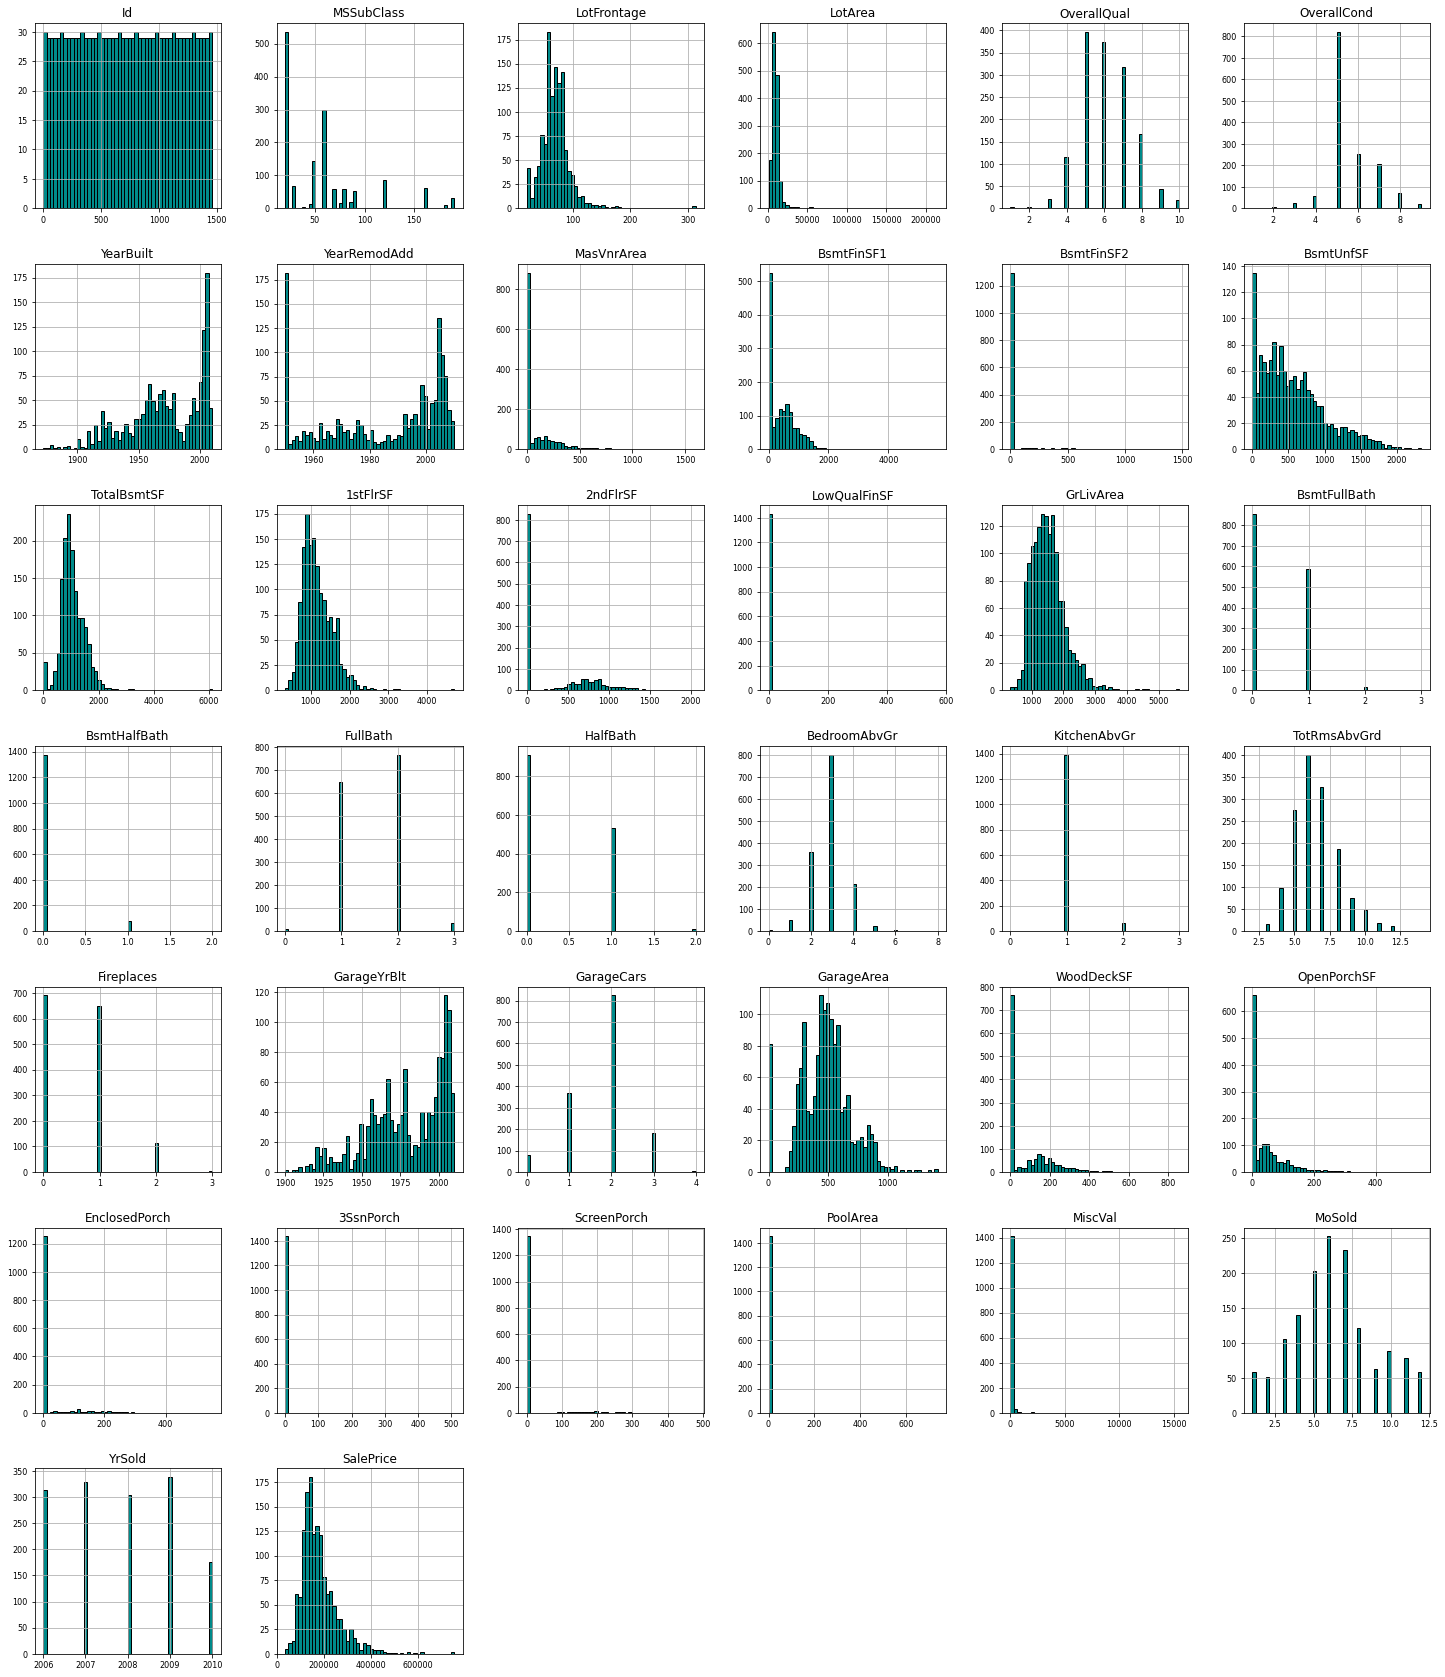

In [18]:
%matplotlib inline 
df_train_num = data.select_dtypes(include=[np.number])
fig_ = df_train_num.hist(figsize=(25, 30), bins=50, color="darkcyan", edgecolor="black", xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

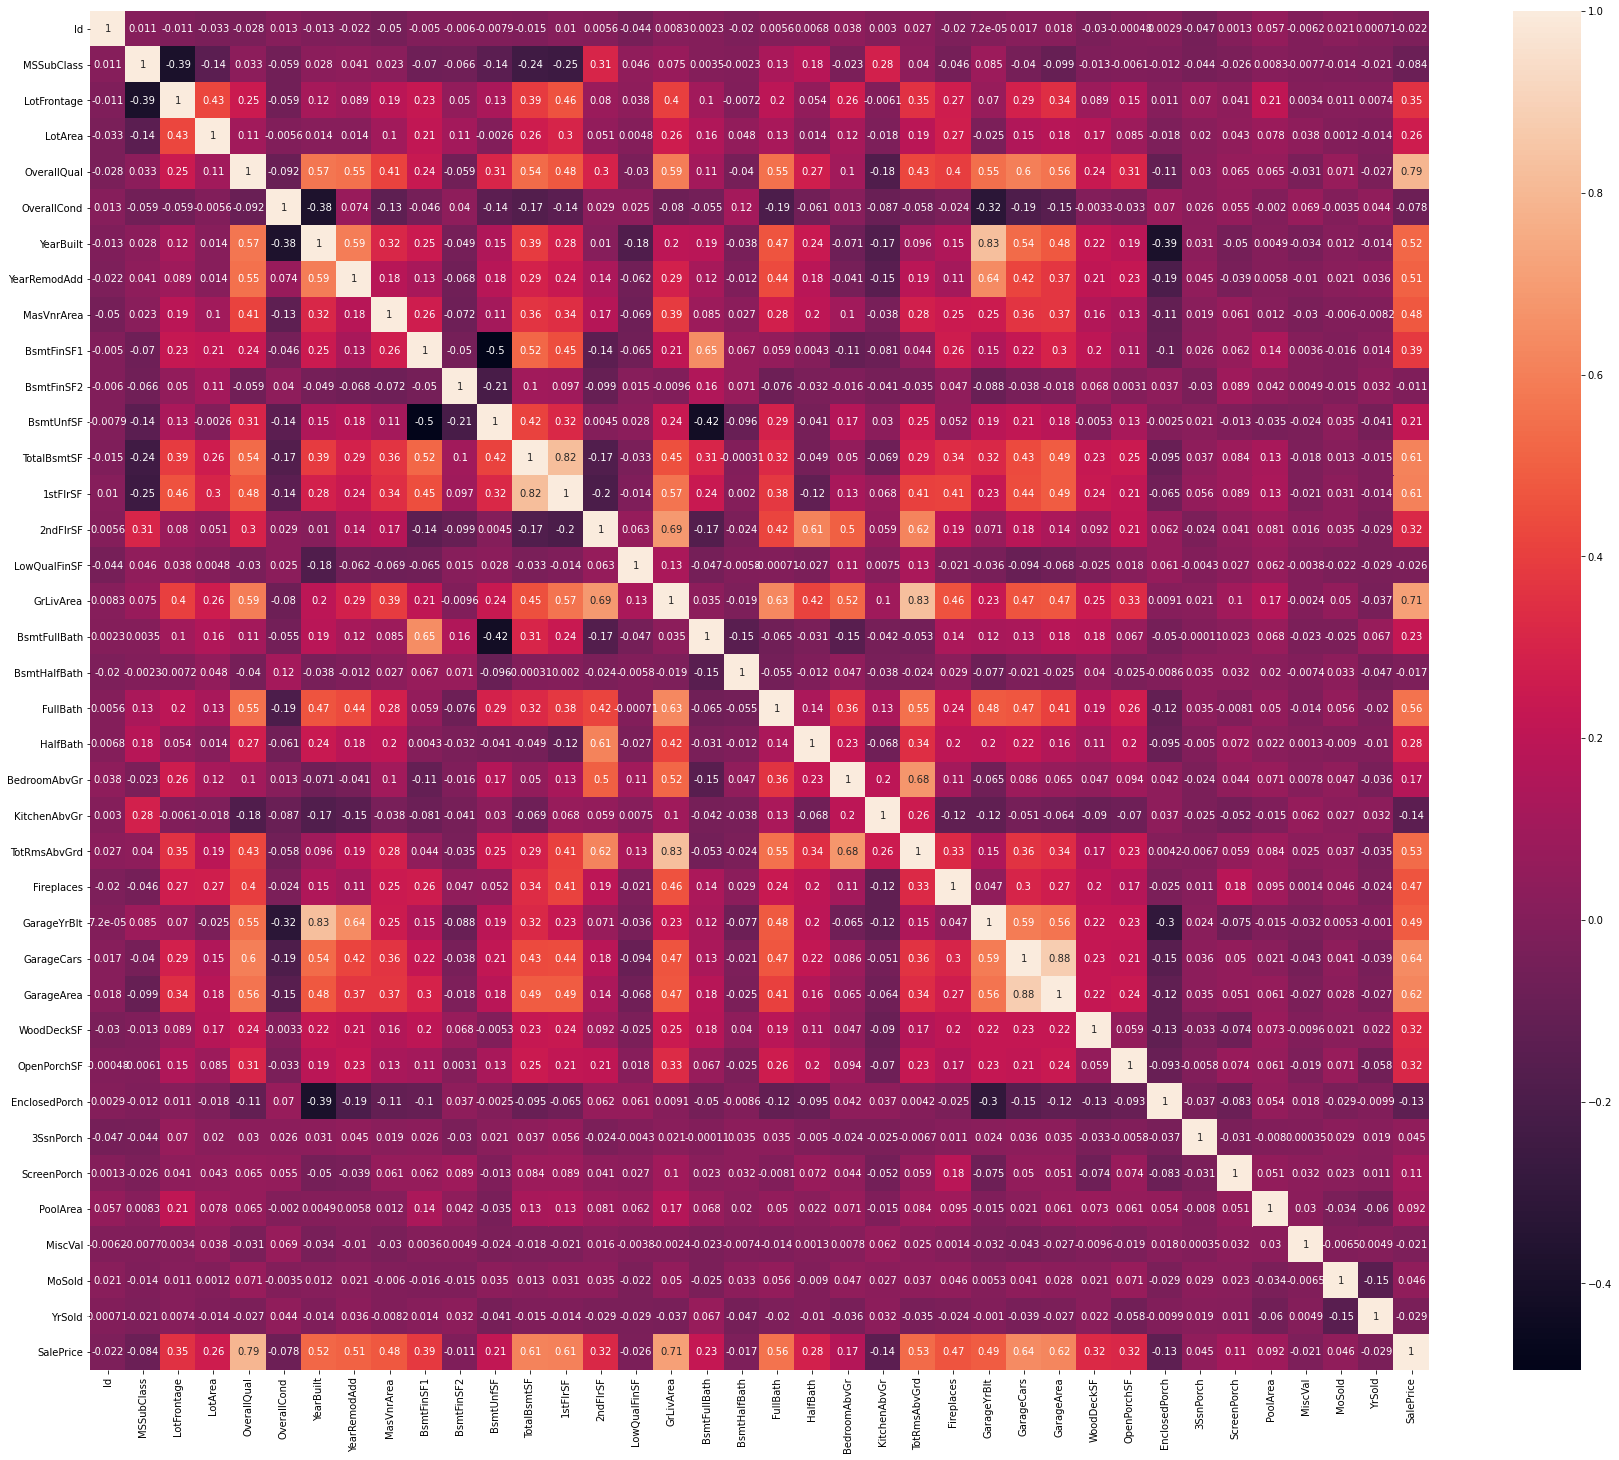

In [19]:
plt.subplots(figsize = (30,25))
sns.heatmap(data.corr(), annot=True)

In [20]:
data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'])
data['Total_Bathrooms'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])
data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [21]:
high_mulicol_columns = ['TotRmsAbvGr', 'GarageCars']

In [34]:
cols_cat = list(data.select_dtypes(include=['object']))
cols_num  = list(data.select_dtypes(exclude=['object']))
cols_num.remove('SalePrice')

In [26]:
print(len(cols_cat)+len(cols_num))

89


In [ ]:
len(list(X))

In [63]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore')),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, cols_num),
    ('cat', cat_pipeline, cols_cat)
])
X = data.drop('SalePrice', axis=1)
#X = full_pipeline.fit_transform(X)
#x_test = full_pipeline.transform(x_test)
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,2416,3.5,61,0,1,1,1,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,WD,Normal,2240,2.5,298,0,0,1,1,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,2272,3.5,42,0,1,1,1,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,WD,Abnorml,1933,2.0,307,0,1,1,1,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,WD,Normal,2853,3.5,276,0,1,1,1,1


In [65]:
from sklearn.model_selection import train_test_split

y = np.log(data['SalePrice'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [32]:
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

This step will lead to data leakage train-valid because the imputer is used before the train-test split

In [66]:
x_train = full_pipeline.fit_transform(x_train)
x_test = full_pipeline.transform(x_test)

In [39]:
x_train

<1168x309 sparse matrix of type '<class 'numpy.float64'>'
	with 102784 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(x_train.toarray())

In [ ]:
from xgboost import XGBRegressor

#xg_model = XGBRegressor(n_estimators=1000)
#xgboost = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                             learning_rate=0.05, max_depth=3, 
#                             min_child_weight=1.7817, n_estimators=2200,
#                             reg_alpha=0.4640, reg_lambda=0.8571,
#                             subsample=0.5213,
#                             random_state =7, nthread = -1)
xg_model = XGBRegressor(random_state=0)
param = {'n_estimators':[500,1000,1500,2000,2500],'learning_rate':np.linspace(0.01,0.3, 10), 'gamma':[0.02,0.04]}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(xg_model, param)
clf.fit(x_train, y_train)
#clf.results_.best_score

#xgboost.fit(x_train, y_train)
#predicted_XGBoost = xgboost.predict(x_test)
#print("Mean Absolute Error using XGBoost: ", np.sqrt(mean_squared_error(y_test, predicted_XGBoost,
#                                                                        squared=False)))

In [ ]:
predicted_XGBoost[:5]

In [ ]:
model = clf.best_estimator_

In [ ]:
xg_model = XGBRegressor(random_state=0,)

In [ ]:
predicted_XGBoost = model.predict(x_test)
print("Mean Absolute Error using XGBoost: ", np.sqrt(mean_squared_error(y_test, predicted_XGBoost,
                                                                        squared=False)))

In [57]:
sub_data = pd.read_csv("test.csv")
X_sub = sub_data.drop(cols, axis=1)
X_sub.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,IR1,HLS,Inside,Gtl,StoneBr,Norm,...,82,0,0,144,0,0,1,2010,WD,Normal


In [69]:
sub_data = pd.read_csv("test.csv")
#X_sub = sub_data.drop(cols, axis=1)
#X_sub = pipeline.transform(sub_data)
X_sub.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Reg,Lvl,Inside,Gtl,NAmes,Feedr,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,IR1,Lvl,Corner,Gtl,NAmes,Norm,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,IR1,Lvl,Inside,Gtl,Gilbert,Norm,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,IR1,HLS,Inside,Gtl,StoneBr,Norm,...,82,0,0,144,0,0,1,2010,WD,Normal


In [ ]:
sub_data = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
sub_data['Id'][:1459]

In [70]:
sub_data = pd.read_csv("test.csv")
#X_sub = sub_data.drop(cols, axis=1)
#X_sub = pipeline.transform(sub_data)
X_sub = full_pipeline.transform(X_sub)

#sub_predict = model.predict(X_sub)
#sub_predict[:]

ValueError: X has 69 features, but ColumnTransformer is expecting 88 features as input.

In [ ]:
submission = pd.DataFrame({
    'Id':sub_data['Id'][:],
    'SalePrice': np.floor(np.exp(sub_predict))
})

submission.to_csv('housing_prices_kaggle2.csv',index=False)

In [ ]:
submission.head()

In [47]:
import tensorflow as tf
from tensorflow import keras

In [45]:
x_train_tf = tf.convert_to_tensor(x_train.toarray())
x_test_tf = tf.convert_to_tensor(x_test.toarray())
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=x_train.shape[1:]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10)
])

In [51]:
model.compile(
    optimizer='adam',
    loss='mae')

In [68]:
history = model.fit(
    x_train_tf, y_train_tf,
    validation_data=(x_test_tf, y_test_tf),
    batch_size=256,
    epochs=100
)

Epoch 1/100
5/5 [==============================] - 0s 14ms/step - loss: 0.1067 - val_loss: 0.1565
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.1180 - val_loss: 0.1634
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0815 - val_loss: 0.1434
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0642 - val_loss: 0.1427
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0623 - val_loss: 0.1461
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0750 - val_loss: 0.1449
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0691 - val_loss: 0.1503
Epoch 8/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0740 - val_loss: 0.1499
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 0.0669 - val_loss: 0.1713
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0797 - val_loss: 0.1576
Epoch 11/100
5/5 [==========